In [4]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [5]:
#pip install lazypredict

In [6]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/distan_lat42.896lon-8.415p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Weather frequencies


M                  73.21%
-RA                 6.38%
BCFG                5.29%
FG                  1.93%
BR                  1.70%
RA                  1.63%
-SHRA               1.60%
VCFG                1.29%
-DZ                 1.14%
SHRA                0.68%
-RA BR              0.54%
-RADZ               0.49%
-DZ BCFG            0.48%
-DZ BR              0.45%
-RA BCFG            0.39%
VCSH                0.24%
RA BR               0.17%
+RA                 0.16%
-RADZ BR            0.15%
-RADZ BCFG          0.15%
BCFG -DZ            0.15%
DZ BR               0.13%
-DZ FG              0.11%
PRFG                0.10%
DZ                  0.10%
+SHRA               0.09%
DZ BCFG             0.09%
FZFG                0.07%
MIFG                0.07%
VCTS                0.07%
TS                  0.06%
RA BCFG             0.06%
-TSRA               0.04%
BR -DZ              0.04%
-DZRA               0.04%
BCFG -RA            0.04%
FG -DZ              0.03%
BR -RA              0.03%
TSRA        

*****************************
Climatology BR FG


No BR/FG    86%
BR/FG       14%
Name: brfg_l, dtype: object

*****************************


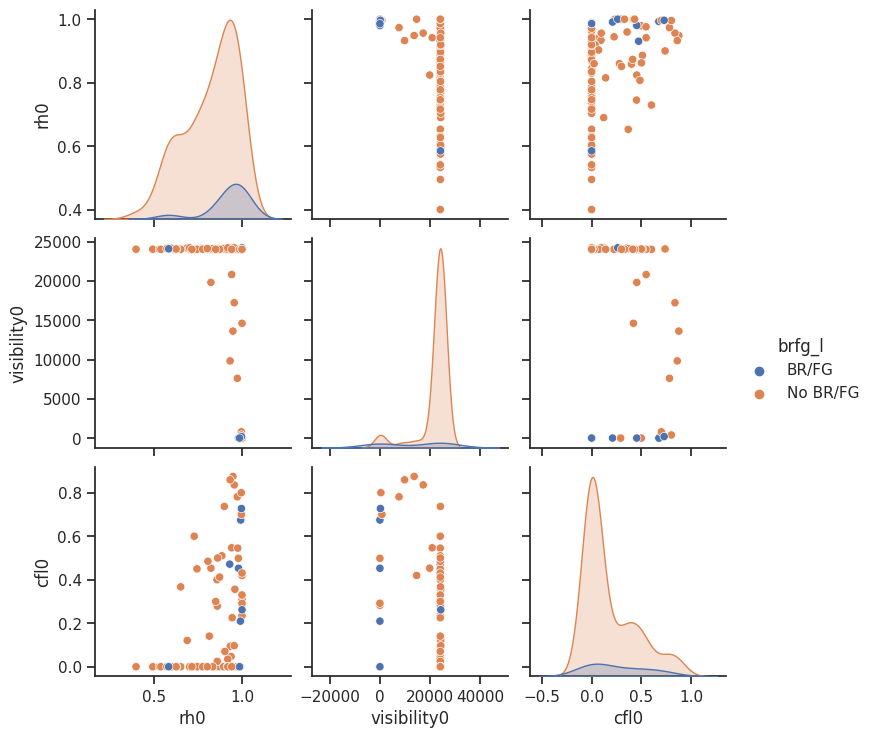

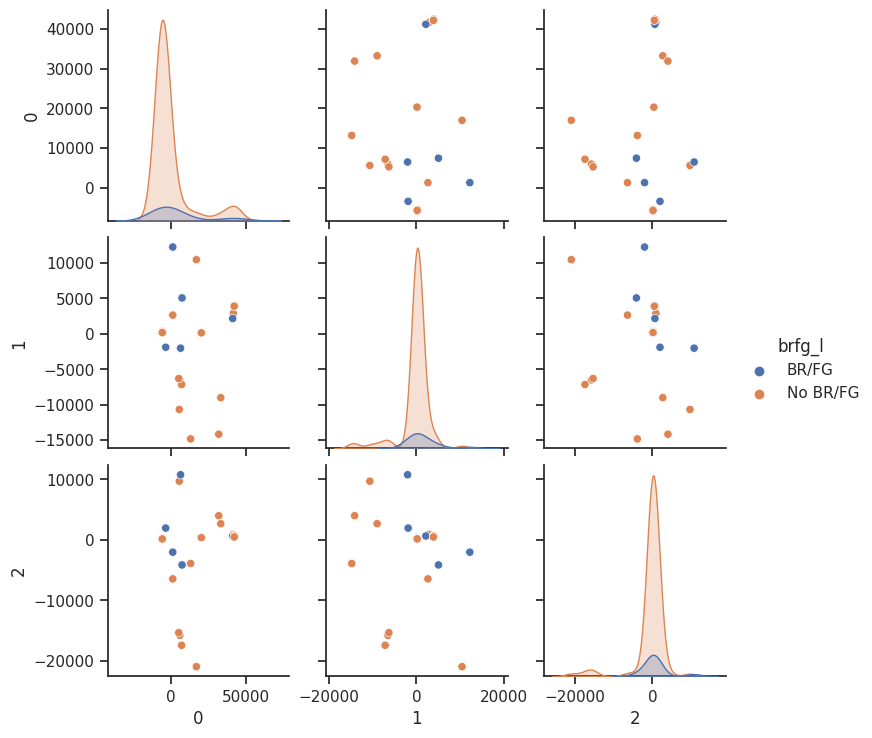

In [7]:
#@title Load station (present weather). Load meteorological model forecast D0. Display relation BRFG with model variables.
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/LESTY2018Y2022.csv",
                          usecols =["time","wxcodes_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Weather frequencies")
display(station["wxcodes_o"].value_counts(normalize=True).map(lambda n: '{:.2%}'.format(n)))

#label br/fg if weather code contains FG or BR
station["brfg_l"] = "No BR/FG"
mask = station['wxcodes_o'].str.contains("BR")
station.loc[mask,["brfg_l"]] = "BR/FG"
mask = station['wxcodes_o'].str.contains("FG")
station.loc[mask,["brfg_l"]] = "BR/FG"
station["brfg_l"]=pd.Categorical(station["brfg_l"])

#display(station.sample(50).head(20))
print("*****************************")
print("Climatology BR FG")
display(station["brfg_l"].value_counts(normalize=True).transform(lambda x: '{:,.0%}'.format(x)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["wxcodes_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["brfg_l","rh0","visibility0","cfl0"]].sample(100)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="brfg_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["brfg_l"] = df_all.brfg_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(100), hue="brfg_l");
plt.show()




Round 0


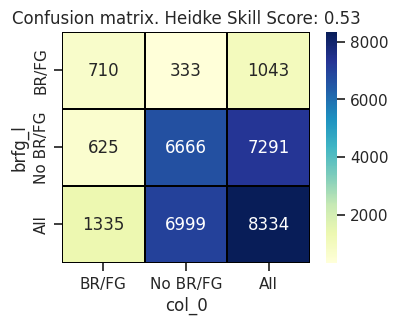

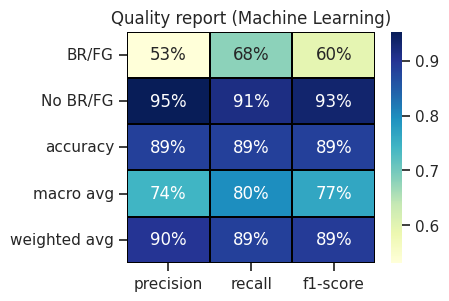

feature feature_per
102    dayofyear        4.8%
100         hour        3.7%
101        month        2.3%
54    wind_gust2        1.7%
32           rh1        1.7%
74         T8502        1.6%
29    wind_gust1        1.6%
7            rh0        1.5%
50          dir2        1.5%
58   visibility2        1.5%

Round 1


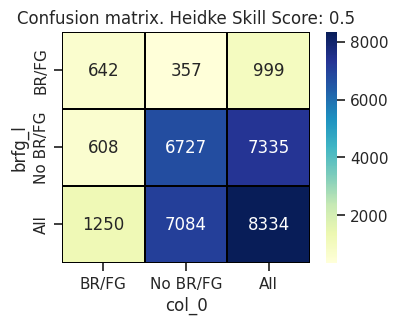

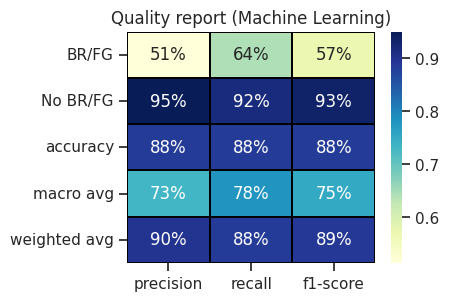

feature feature_per
102   dayofyear        4.9%
100        hour        3.2%
101       month        2.2%
54   wind_gust2        1.7%
103  weekofyear        1.6%
7           rh0        1.6%
32          rh1        1.6%
4    wind_gust0        1.5%
75         dir3        1.5%
17         cfh0        1.4%

Round 2


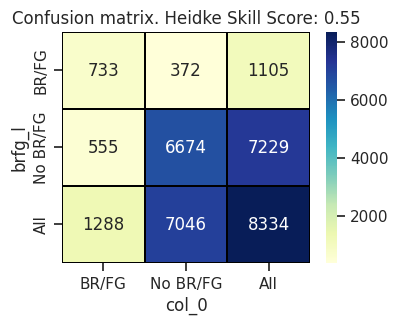

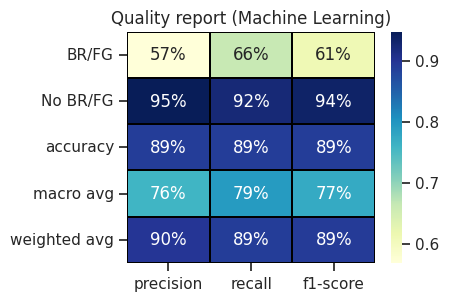

feature feature_per
102    dayofyear        4.9%
100         hour        3.8%
101        month        2.6%
7            rh0        1.6%
29    wind_gust1        1.6%
54    wind_gust2        1.6%
83   visibility3        1.6%
32           rh1        1.5%
25          dir1        1.4%
75          dir3        1.4%

Round 3


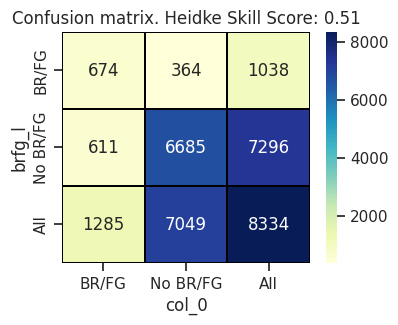

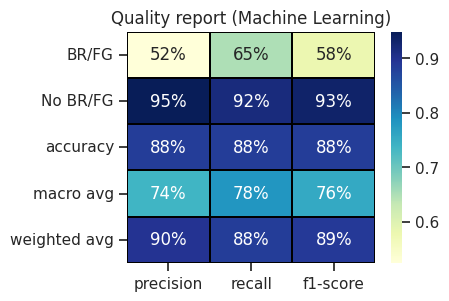

feature feature_per
102    dayofyear        4.5%
100         hour        3.5%
101        month        2.1%
74         T8502        1.6%
54    wind_gust2        1.6%
29    wind_gust1        1.6%
89        shflx3        1.5%
67          cfh2        1.4%
58   visibility2        1.4%
33   visibility1        1.4%

Round 4


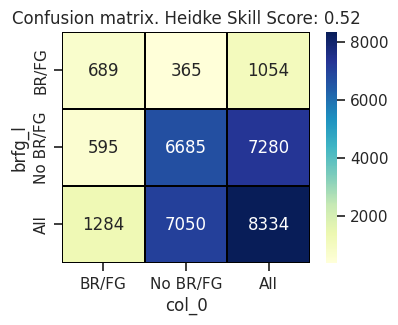

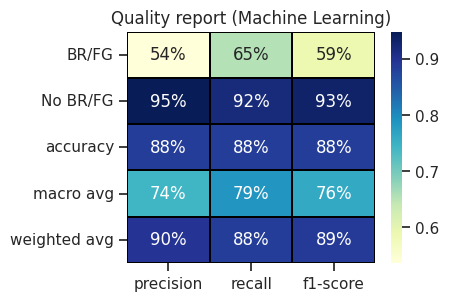

feature feature_per
102   dayofyear        4.4%
100        hour        3.5%
101       month        2.2%
54   wind_gust2        1.8%
74        T8502        1.7%
7           rh0        1.7%
75         dir3        1.6%
32          rh1        1.6%
25         dir1        1.5%
57          rh2        1.5%

Round 5


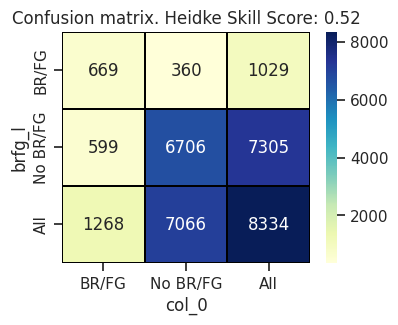

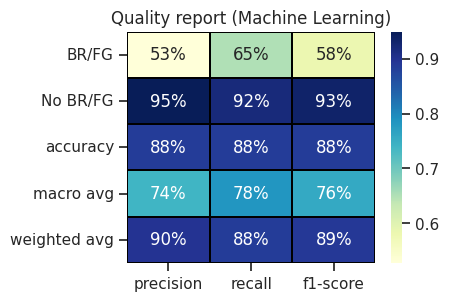

feature feature_per
102   dayofyear        4.6%
100        hour        3.7%
101       month        2.2%
29   wind_gust1        1.7%
32          rh1        1.7%
74        T8502        1.6%
7           rh0        1.5%
75         dir3        1.4%
21      HGT5000        1.4%
54   wind_gust2        1.4%

Round 6


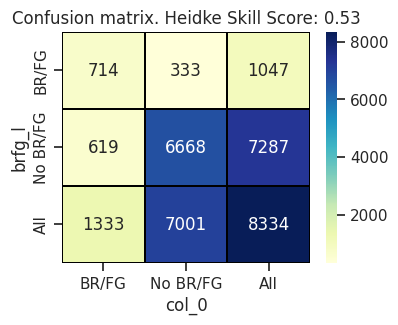

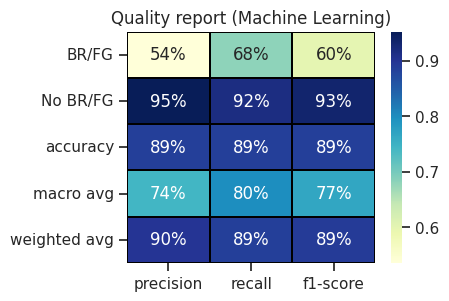

feature feature_per
102    dayofyear        4.6%
100         hour        4.0%
101        month        2.1%
7            rh0        2.0%
29    wind_gust1        1.7%
103   weekofyear        1.5%
75          dir3        1.5%
58   visibility2        1.5%
37         prec1        1.5%
23         T5000        1.5%

Round 7


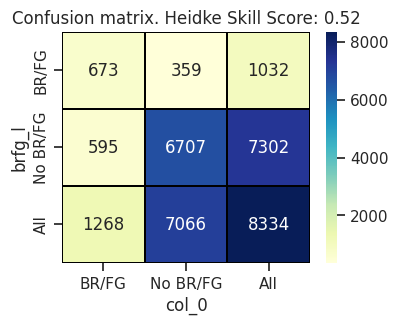

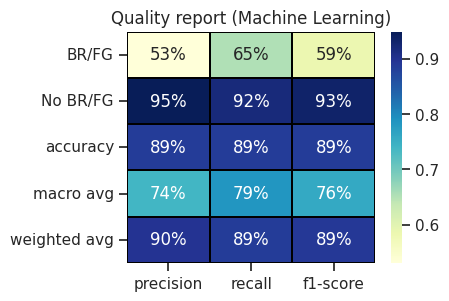

feature feature_per
102    dayofyear        4.6%
100         hour        3.9%
101        month        2.2%
32           rh1        1.9%
74         T8502        1.7%
7            rh0        1.6%
54    wind_gust2        1.5%
103   weekofyear        1.5%
58   visibility2        1.4%
25          dir1        1.4%

Round 8


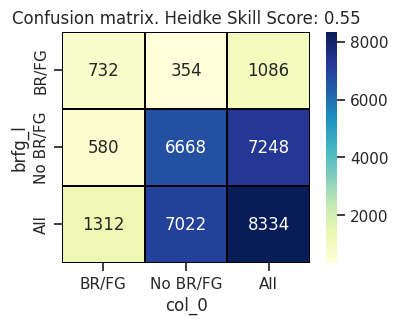

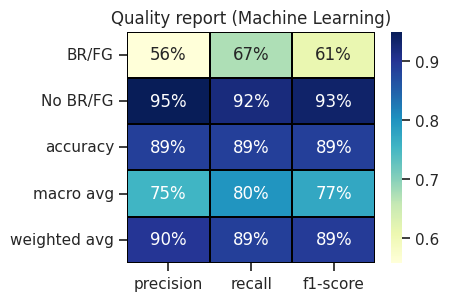

feature feature_per
102    dayofyear        4.9%
100         hour        3.8%
101        month        2.5%
7            rh0        1.7%
54    wind_gust2        1.6%
74         T8502        1.6%
58   visibility2        1.5%
103   weekofyear        1.5%
57           rh2        1.5%
32           rh1        1.4%

Round 9


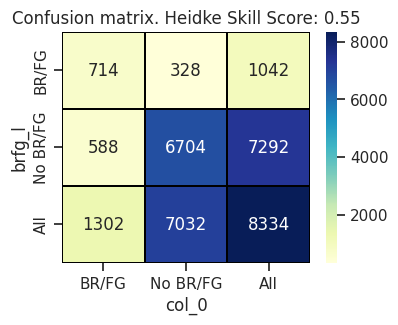

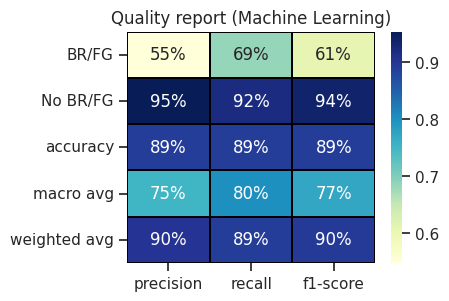

feature feature_per
102    dayofyear        4.7%
100         hour        3.7%
101        month        2.5%
17          cfh0        1.7%
54    wind_gust2        1.7%
29    wind_gust1        1.7%
74         T8502        1.6%
0           dir0        1.5%
7            rh0        1.5%
83   visibility3        1.4%


HSS stadistics
             HSS
count  10.000000
mean    0.528336
std     0.015184
min     0.504957
25%     0.517360
50%     0.527215
75%     0.542924
max     0.548124
Shapiro test normality
p value: 0.48144471645355225
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2523.5021315059284
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.02 minutes


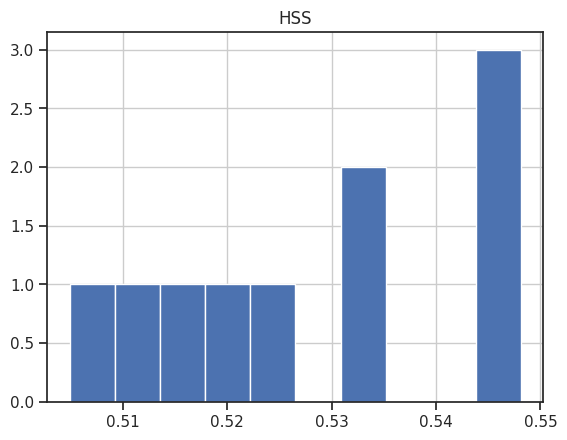

In [8]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.brfg_l
X = df_all.iloc[:,1:]


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [9]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/brfg_LEST_d0.al", 'wb'))

Round 0


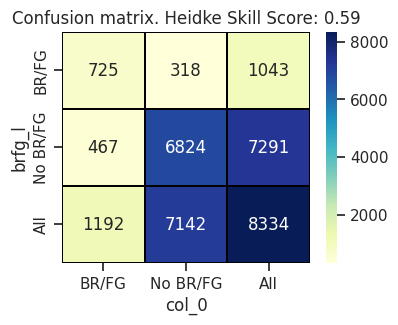

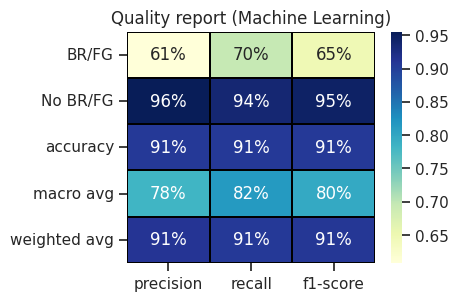

feature feature_per
100         hour        4.3%
7            rh0        3.6%
82           rh3        3.4%
57           rh2        3.3%
32           rh1        3.0%
8    visibility0        2.5%
9         lhflx0        2.4%
4     wind_gust0        1.9%
33   visibility1        1.9%
54    wind_gust2        1.8%

Round 1


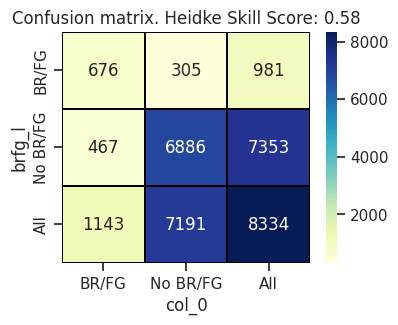

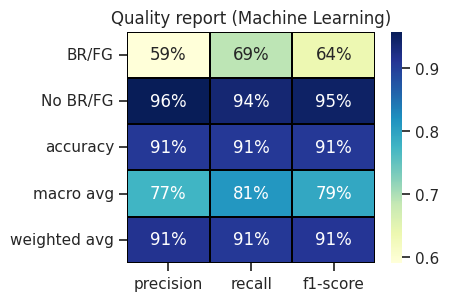

feature feature_per
100         hour        4.4%
82           rh3        3.0%
7            rh0        2.9%
57           rh2        2.9%
8    visibility0        2.8%
32           rh1        2.6%
34        lhflx1        2.4%
33   visibility1        2.4%
84        lhflx3        1.8%
9         lhflx0        1.7%

Round 2


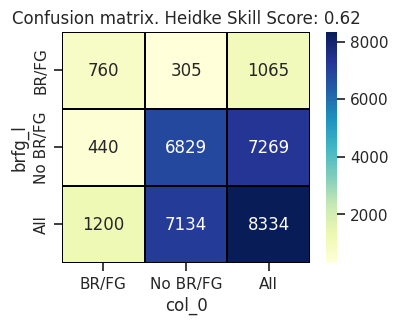

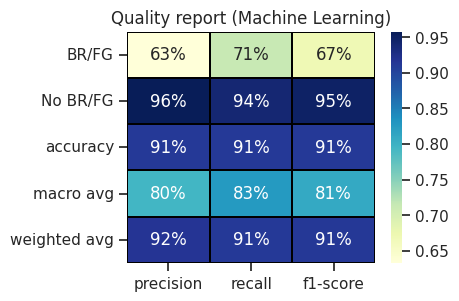

feature feature_per
100         hour        4.9%
32           rh1        2.8%
7            rh0        2.6%
82           rh3        2.5%
84        lhflx3        2.3%
57           rh2        2.3%
8    visibility0        2.3%
59        lhflx2        2.2%
34        lhflx1        2.0%
83   visibility3        1.9%

Round 3


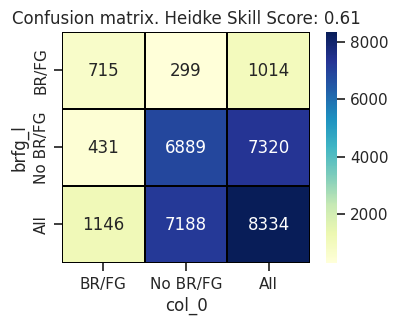

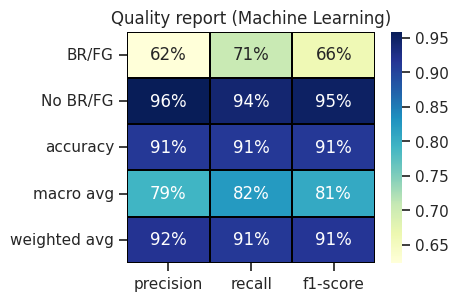

feature feature_per
100         hour        5.1%
82           rh3        3.4%
57           rh2        2.5%
8    visibility0        2.3%
7            rh0        2.3%
84        lhflx3        2.3%
33   visibility1        2.3%
32           rh1        2.3%
59        lhflx2        2.0%
4     wind_gust0        1.9%

Round 4


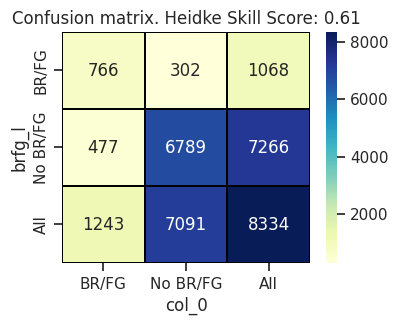

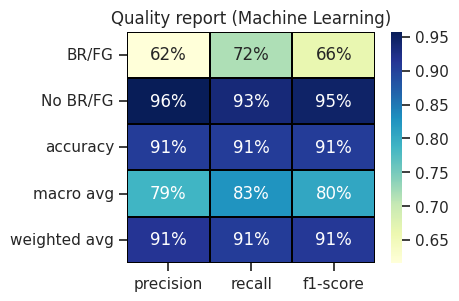

feature feature_per
100         hour        5.0%
82           rh3        3.5%
32           rh1        3.1%
57           rh2        2.9%
7            rh0        2.8%
84        lhflx3        2.2%
8    visibility0        2.0%
34        lhflx1        2.0%
83   visibility3        2.0%
33   visibility1        2.0%

Round 5


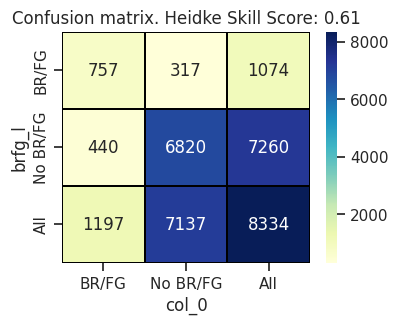

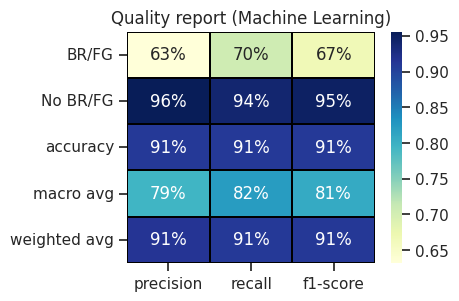

feature feature_per
100         hour        5.7%
7            rh0        2.6%
57           rh2        2.5%
32           rh1        2.5%
82           rh3        2.4%
84        lhflx3        2.2%
8    visibility0        2.1%
4     wind_gust0        2.0%
33   visibility1        2.0%
54    wind_gust2        1.8%

Round 6


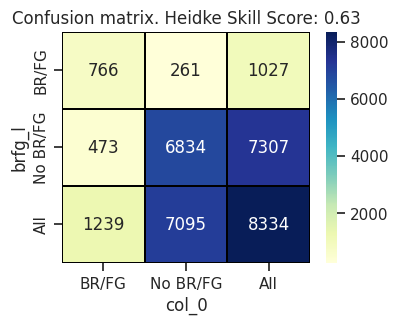

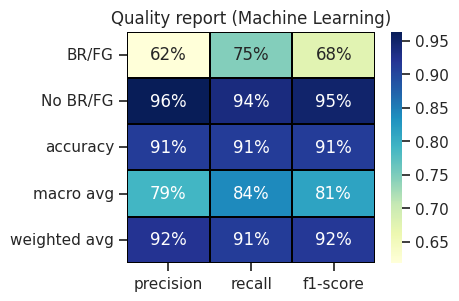

feature feature_per
100         hour        5.1%
7            rh0        3.7%
57           rh2        3.5%
8    visibility0        2.5%
32           rh1        2.5%
84        lhflx3        2.4%
82           rh3        2.1%
59        lhflx2        1.9%
34        lhflx1        1.8%
79    wind_gust3        1.7%

Round 7


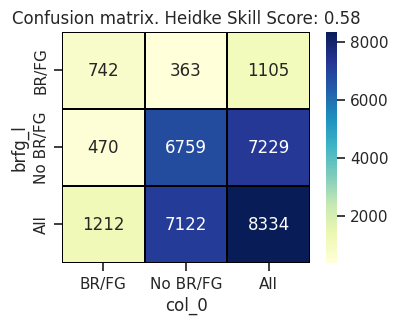

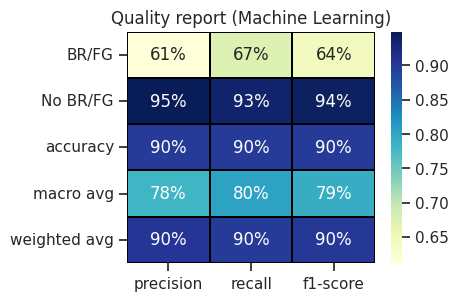

feature feature_per
100         hour        4.4%
32           rh1        3.1%
57           rh2        3.1%
7            rh0        3.0%
33   visibility1        2.7%
82           rh3        2.1%
83   visibility3        2.1%
4     wind_gust0        2.0%
84        lhflx3        1.9%
29    wind_gust1        1.8%

Round 8


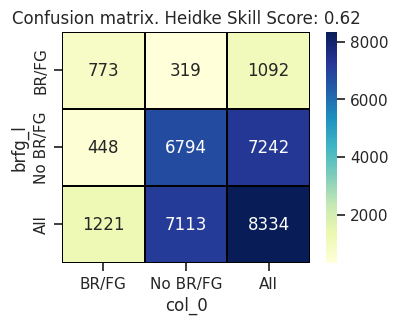

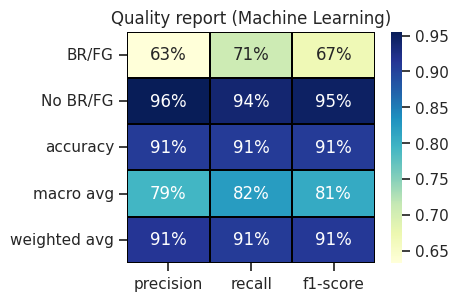

feature feature_per
100         hour        5.4%
57           rh2        3.1%
7            rh0        2.9%
82           rh3        2.8%
8    visibility0        2.8%
32           rh1        2.5%
34        lhflx1        2.2%
33   visibility1        2.1%
54    wind_gust2        1.9%
4     wind_gust0        1.9%

Round 9


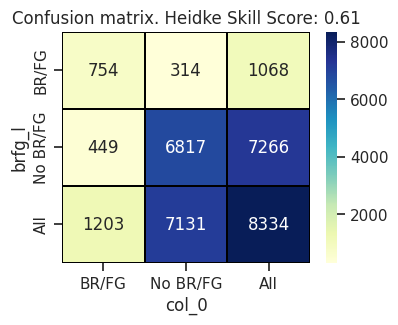

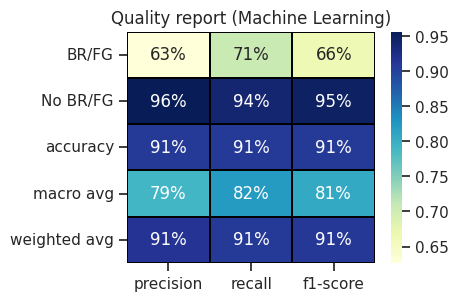

feature feature_per
100         hour        4.8%
32           rh1        3.4%
82           rh3        2.7%
57           rh2        2.6%
7            rh0        2.4%
8    visibility0        2.4%
59        lhflx2        2.1%
33   visibility1        2.1%
4     wind_gust0        2.1%
84        lhflx3        2.0%


HSS stadistics
             HSS
count  10.000000
mean    0.606787
std     0.014745
min     0.582582
25%     0.598249
50%     0.611590
75%     0.614935
max     0.625632
Shapiro test normality
p value: 0.1351204812526703
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 3123.3330411730776
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 3.93 minutes


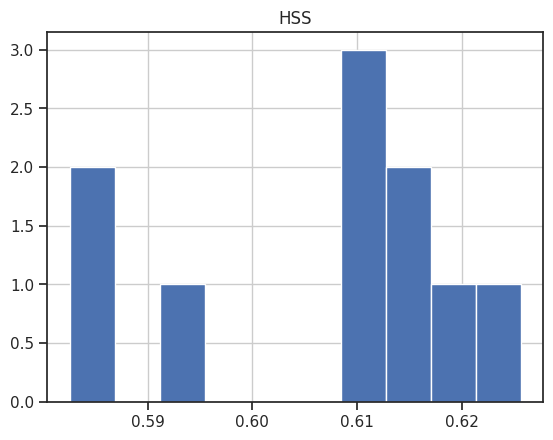

In [10]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.brfg_l
X = df_all.iloc[:,1:]


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")







In [11]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/brfg_LEST_d0.al", 'wb'))

*****************************


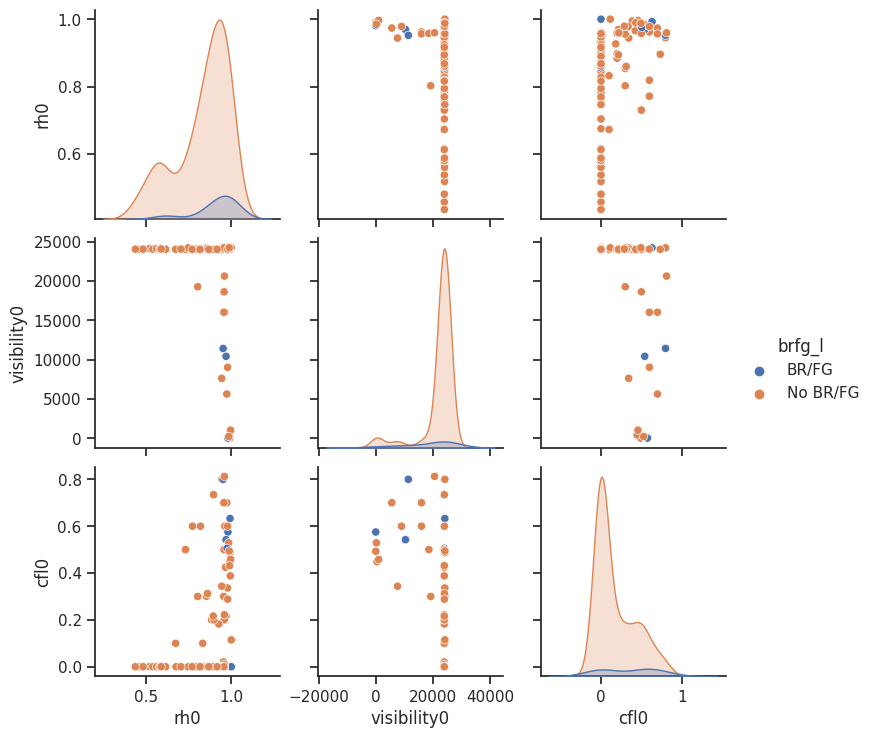

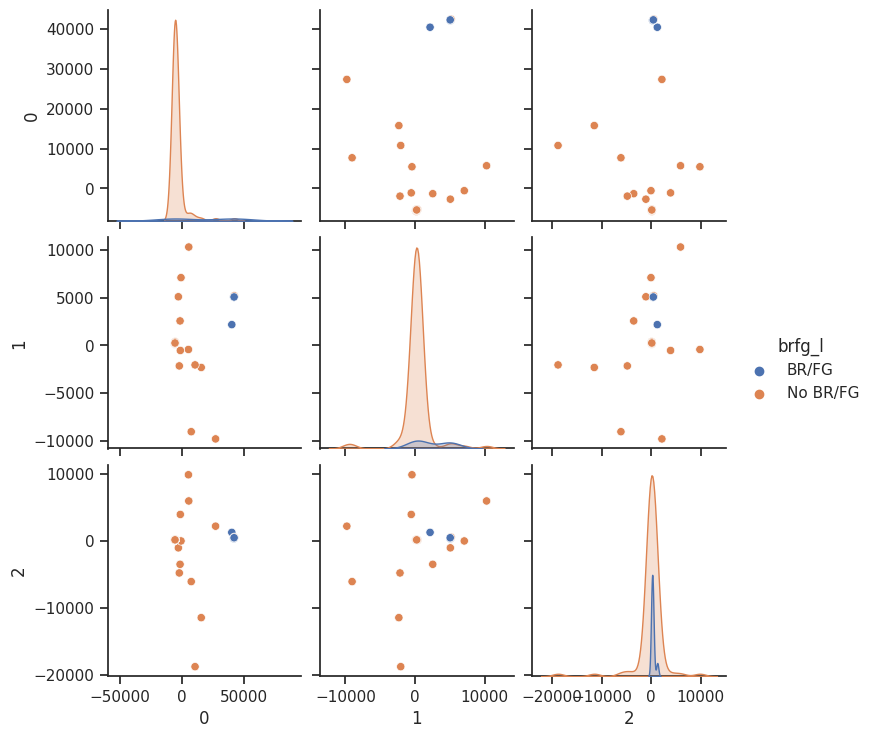

In [12]:
#@title Load meteorological model forecast D1. Display relation BRFG with model variables.
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")


#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["wxcodes_o",]).dropna()
#display(df_all)

#display relation br fg with meteorological model variables
print("*****************************")

sns.set_theme(style="ticks")
df = df_all[["brfg_l","rh0","visibility0","cfl0"]].sample(100)
#plt.figure(figsize=(12, 10))
#plt.title("Display relation br fg with meteorological model variables sample=100")
g1 = sns.pairplot(df, hue="brfg_l");
plt.show()

#display relation br fg with meteorological PCA
df_pca = pd.DataFrame(PCA(n_components=3).fit_transform(df_all.iloc[:,1:]),
                                                       index =df_all.index)
df_pca["brfg_l"] = df_all.brfg_l
#plt.figure(figsize=(12, 10))
#plt.title("PCA analysis sample=100")
g2 = sns.pairplot(df_pca.sample(100), hue="brfg_l");
plt.show()

Round 0


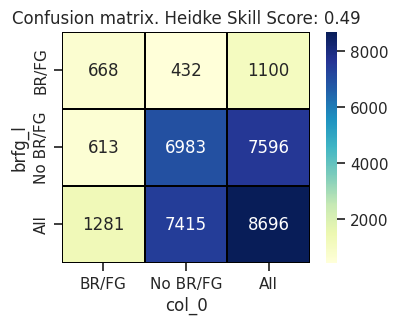

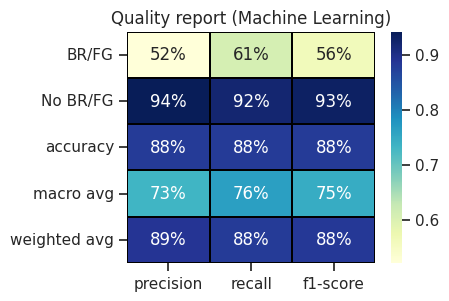

feature feature_per
102    dayofyear        4.7%
100         hour        3.5%
101        month        2.1%
7            rh0        1.7%
103   weekofyear        1.6%
50          dir2        1.6%
17          cfh0        1.6%
54    wind_gust2        1.6%
58   visibility2        1.5%
12         prec0        1.5%

Round 1


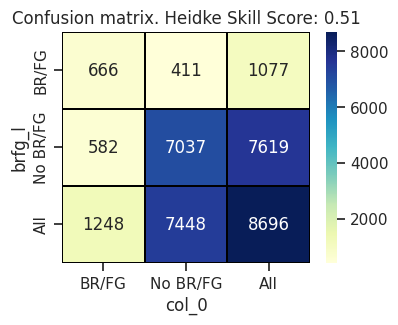

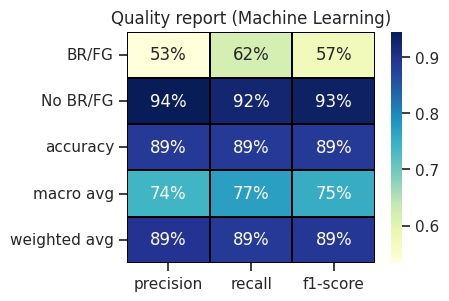

feature feature_per
102    dayofyear        4.6%
100         hour        3.3%
101        month        2.2%
62         prec2        2.1%
54    wind_gust2        1.8%
50          dir2        1.8%
37         prec1        1.7%
58   visibility2        1.5%
103   weekofyear        1.4%
12         prec0        1.4%

Round 2


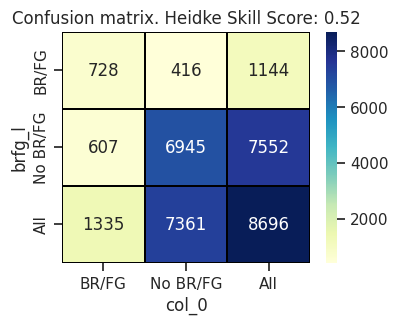

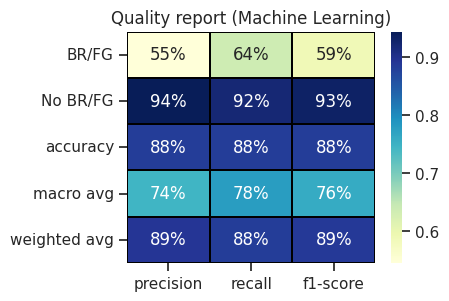

feature feature_per
102   dayofyear        4.7%
100        hour        3.2%
101       month        2.1%
50         dir2        2.1%
54   wind_gust2        1.8%
17         cfh0        1.6%
25         dir1        1.6%
103  weekofyear        1.5%
7           rh0        1.5%
62        prec2        1.4%

Round 3


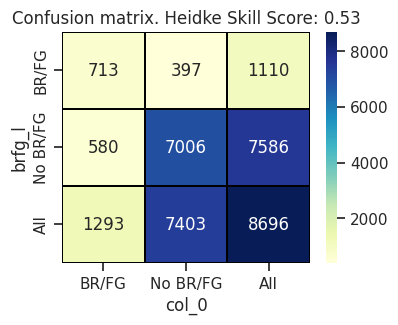

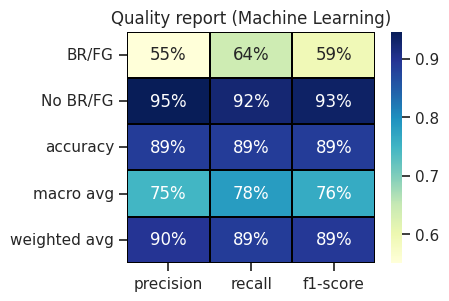

feature feature_per
102    dayofyear        4.3%
100         hour        3.5%
101        month        2.2%
103   weekofyear        1.8%
7            rh0        1.7%
62         prec2        1.7%
50          dir2        1.6%
17          cfh0        1.6%
37         prec1        1.6%
58   visibility2        1.5%

Round 4


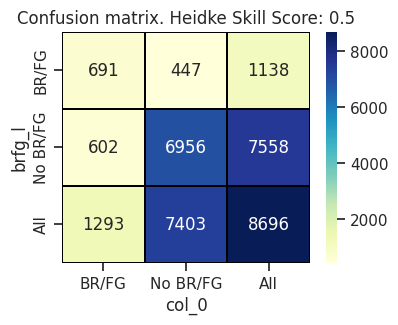

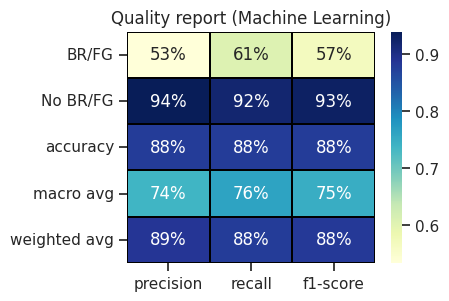

feature feature_per
102   dayofyear        4.4%
100        hour        3.5%
101       month        2.2%
103  weekofyear        1.9%
12        prec0        1.7%
7           rh0        1.7%
50         dir2        1.6%
87        prec3        1.5%
37        prec1        1.5%
32          rh1        1.4%

Round 5


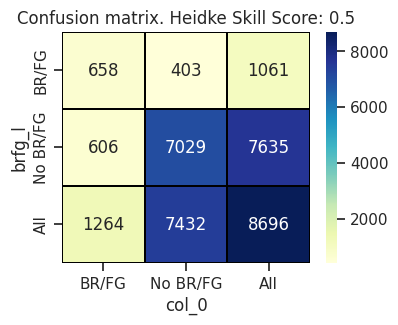

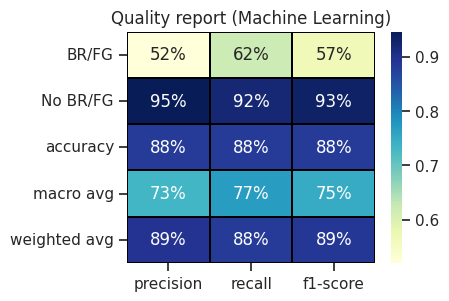

feature feature_per
102   dayofyear        4.8%
100        hour        3.4%
101       month        2.3%
103  weekofyear        1.8%
12        prec0        1.8%
37        prec1        1.8%
0          dir0        1.7%
32          rh1        1.6%
7           rh0        1.6%
54   wind_gust2        1.6%

Round 6


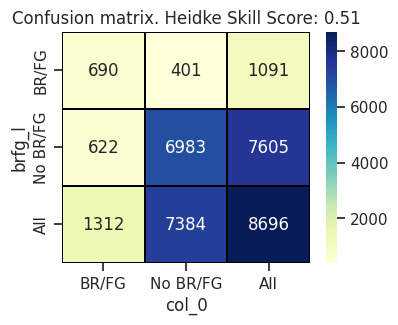

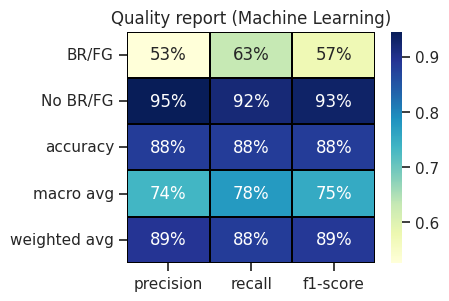

feature feature_per
102    dayofyear        4.6%
100         hour        3.4%
101        month        2.4%
17          cfh0        1.8%
103   weekofyear        1.7%
58   visibility2        1.6%
50          dir2        1.6%
54    wind_gust2        1.6%
7            rh0        1.5%
25          dir1        1.4%

Round 7


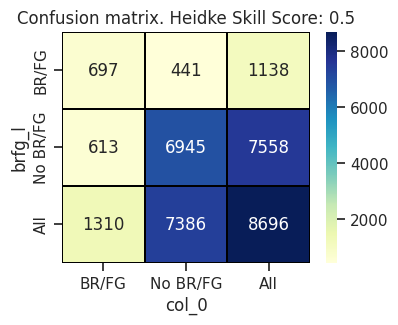

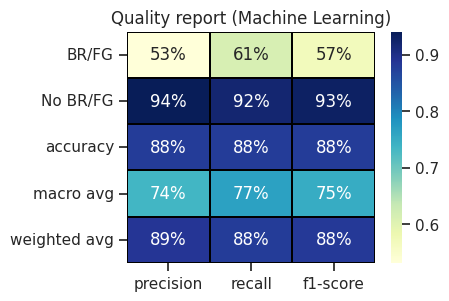

feature feature_per
102   dayofyear        4.7%
100        hour        3.2%
101       month        2.2%
54   wind_gust2        1.9%
12        prec0        1.7%
17         cfh0        1.7%
87        prec3        1.7%
50         dir2        1.6%
103  weekofyear        1.6%
0          dir0        1.5%

Round 8


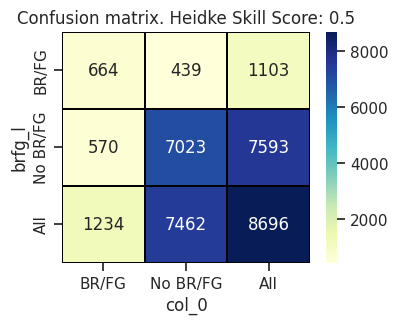

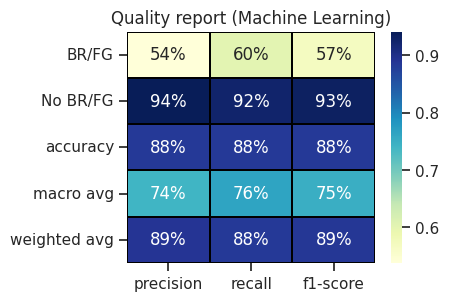

feature feature_per
102    dayofyear        4.8%
100         hour        3.4%
101        month        2.2%
54    wind_gust2        1.8%
103   weekofyear        1.6%
50          dir2        1.6%
58   visibility2        1.5%
0           dir0        1.5%
75          dir3        1.5%
25          dir1        1.4%

Round 9


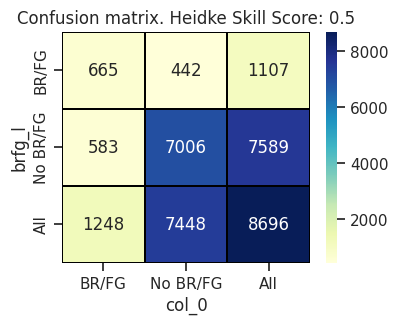

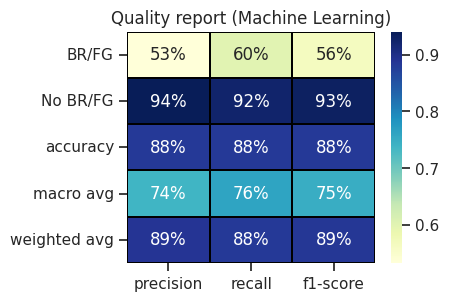

feature feature_per
102   dayofyear        4.7%
100        hour        3.0%
101       month        2.1%
103  weekofyear        1.8%
12        prec0        1.8%
54   wind_gust2        1.7%
50         dir2        1.7%
25         dir1        1.5%
14       shflx0        1.5%
32          rh1        1.5%


HSS stadistics
             HSS
count  10.000000
mean    0.504997
std     0.011159
min     0.491959
25%     0.498859
50%     0.500557
75%     0.507232
max     0.528682
Shapiro test normality
p value: 0.10582589358091354
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2152.966852705807
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.05 minutes


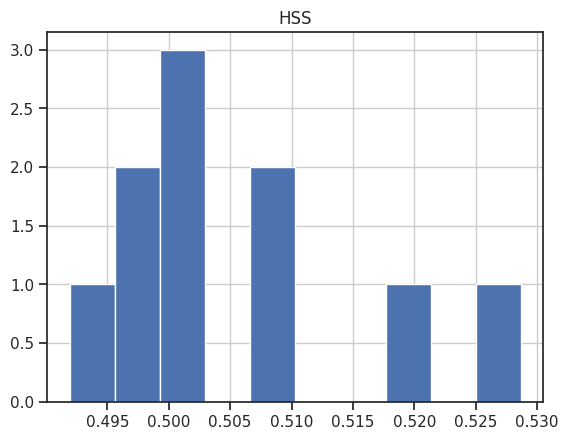

In [13]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.brfg_l
X = df_all.iloc[:,1:]


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")

In [14]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/brfg_LEST_d1.al", 'wb'))

Round 0


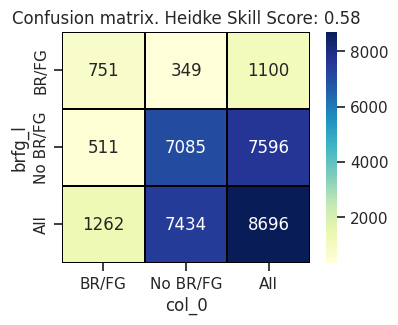

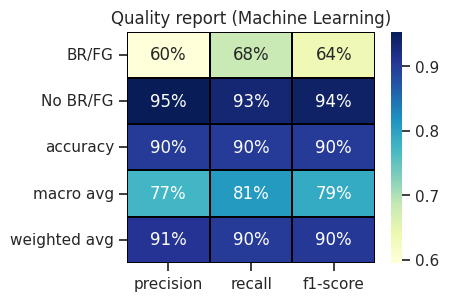

feature feature_per
100         hour        4.9%
7            rh0        3.1%
34        lhflx1        2.4%
82           rh3        2.4%
32           rh1        2.2%
57           rh2        2.1%
8    visibility0        2.0%
59        lhflx2        1.9%
54    wind_gust2        1.9%
33   visibility1        1.8%

Round 1


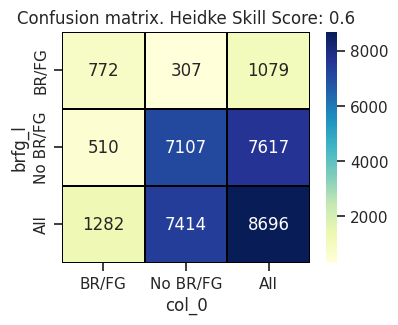

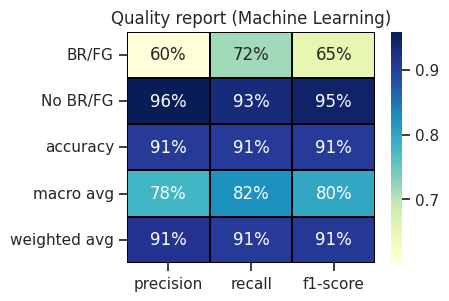

feature feature_per
100         hour        4.6%
32           rh1        2.9%
7            rh0        2.9%
82           rh3        2.5%
68          cfl2        2.2%
8    visibility0        2.1%
54    wind_gust2        1.9%
84        lhflx3        1.9%
57           rh2        1.8%
34        lhflx1        1.7%

Round 2


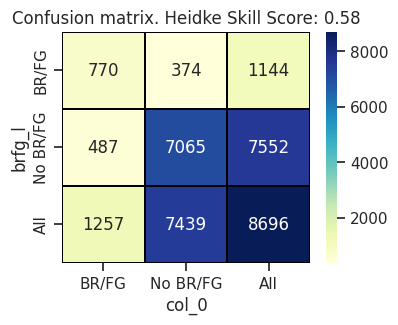

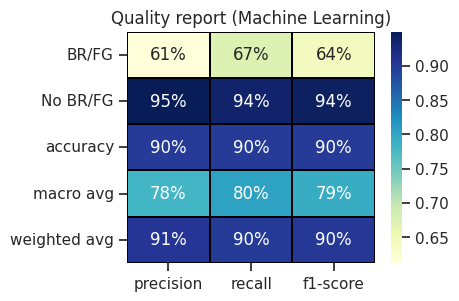

feature feature_per
100        hour        5.2%
82          rh3        3.3%
84       lhflx3        2.5%
7           rh0        2.4%
32          rh1        2.3%
57          rh2        2.1%
59       lhflx2        2.0%
54   wind_gust2        2.0%
93         cfl3        1.8%
4    wind_gust0        1.7%

Round 3


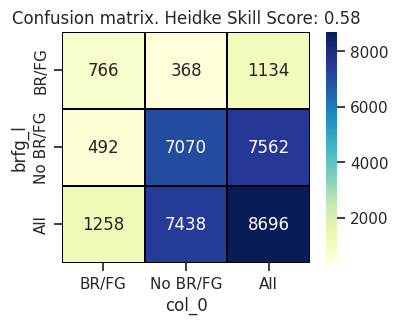

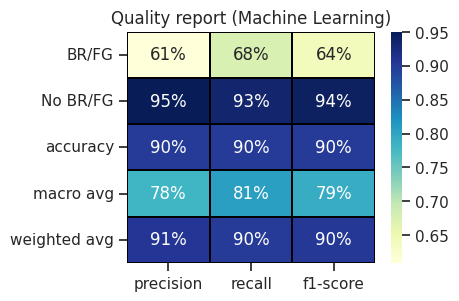

feature feature_per
100         hour        5.9%
7            rh0        2.2%
33   visibility1        2.2%
57           rh2        2.1%
82           rh3        2.1%
32           rh1        2.1%
54    wind_gust2        1.9%
8    visibility0        1.9%
9         lhflx0        1.8%
59        lhflx2        1.7%

Round 4


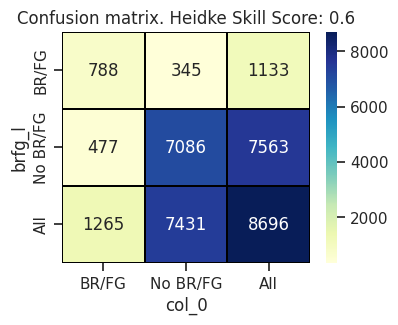

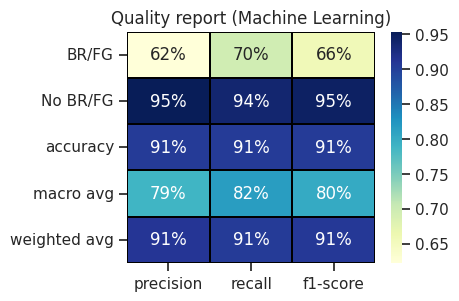

feature feature_per
100         hour        5.3%
7            rh0        2.7%
84        lhflx3        2.6%
32           rh1        2.3%
8    visibility0        2.1%
59        lhflx2        2.0%
82           rh3        2.0%
33   visibility1        2.0%
57           rh2        1.9%
9         lhflx0        1.9%

Round 5


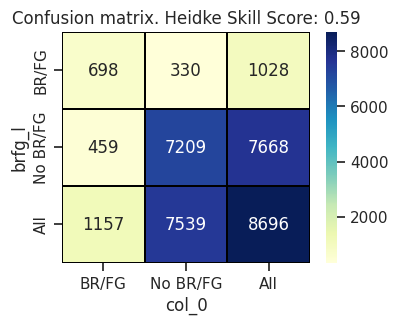

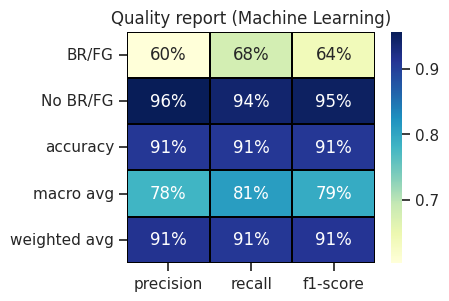

feature feature_per
100         hour        4.8%
7            rh0        2.6%
32           rh1        2.6%
59        lhflx2        2.3%
82           rh3        2.2%
33   visibility1        2.2%
57           rh2        2.1%
84        lhflx3        2.1%
34        lhflx1        1.9%
54    wind_gust2        1.9%

Round 6


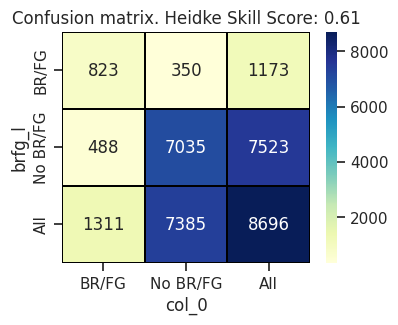

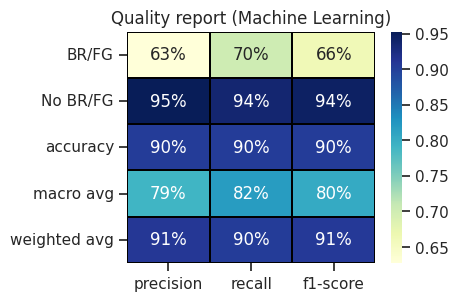

feature feature_per
100         hour        5.0%
57           rh2        3.0%
84        lhflx3        2.3%
7            rh0        2.3%
82           rh3        2.1%
43          cfl1        2.0%
8    visibility0        2.0%
32           rh1        2.0%
54    wind_gust2        2.0%
34        lhflx1        1.9%

Round 7


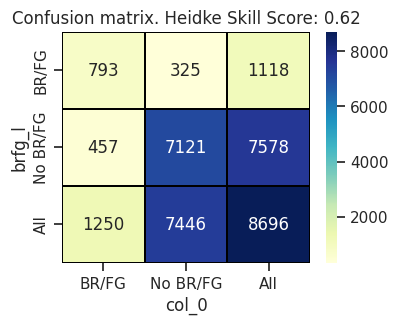

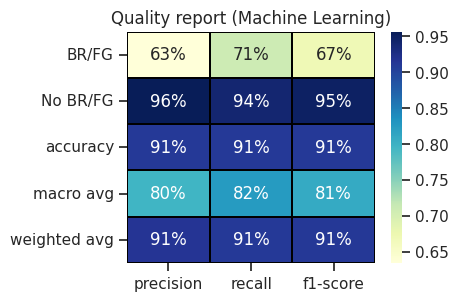

feature feature_per
100         hour        5.3%
32           rh1        2.7%
7            rh0        2.6%
82           rh3        2.3%
84        lhflx3        2.1%
34        lhflx1        1.9%
93          cfl3        1.9%
8    visibility0        1.8%
33   visibility1        1.8%
57           rh2        1.7%

Round 8


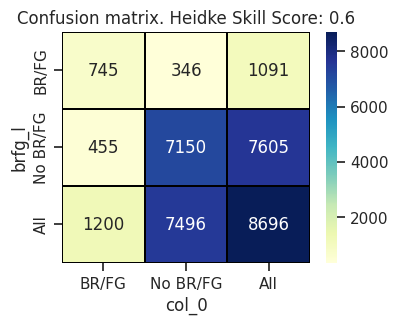

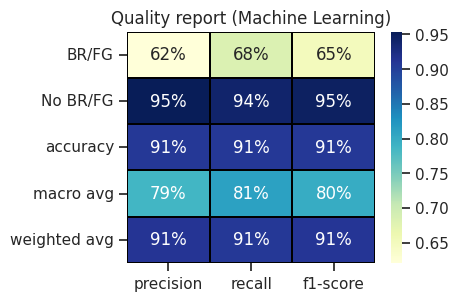

feature feature_per
100         hour        5.3%
7            rh0        2.8%
84        lhflx3        2.3%
32           rh1        2.2%
82           rh3        2.2%
57           rh2        1.9%
33   visibility1        1.9%
8    visibility0        1.8%
4     wind_gust0        1.8%
34        lhflx1        1.7%

Round 9


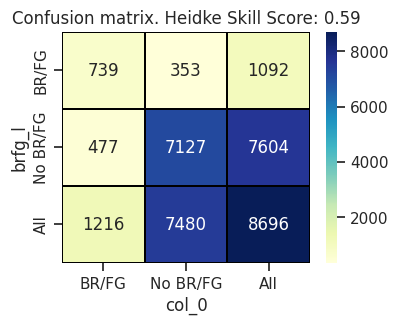

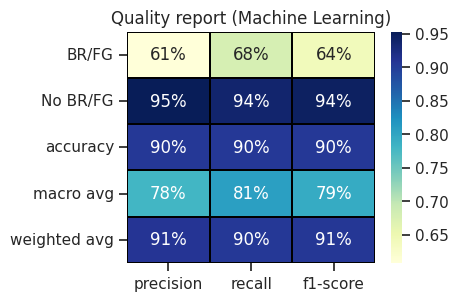

feature feature_per
100         hour        5.0%
32           rh1        3.0%
7            rh0        2.3%
57           rh2        2.3%
82           rh3        2.2%
34        lhflx1        2.1%
8    visibility0        2.0%
84        lhflx3        1.8%
4     wind_gust0        1.8%
33   visibility1        1.8%


HSS stadistics
             HSS
count  10.000000
mean    0.594384
std     0.012501
min     0.578994
25%     0.584469
50%     0.592345
75%     0.601956
max     0.617901
Shapiro test normality
p value: 0.4375477433204651
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2987.8489374654982
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 4.18 minutes


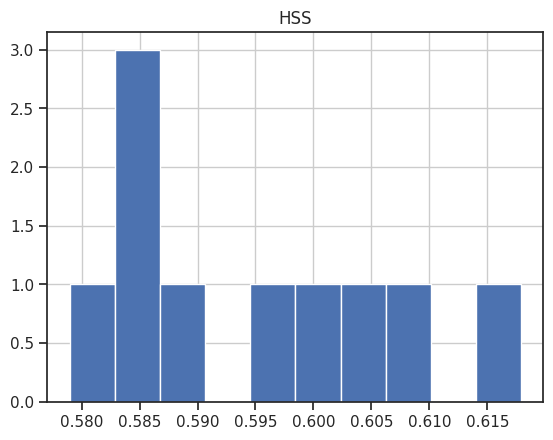

In [15]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.brfg_l
X = df_all.iloc[:,1:]


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [16]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/brfg_LEST_d1.al", 'wb'))